In [37]:
import requests
import json
import matplotlib.pyplot as plt
import pickle
from collections import Counter
import os

First, let's set the league_id and current GW

In [38]:
league_id = '780695' ##CHANGE ME to your league's ID 
GW='1'

# Gameweek specific info
- chip usage
- captaincy
- most owned players

First, we need to get the ID->Name and ID->Price mapping for all players

In [39]:
# Send a GET request to the FPL website
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(url)
data = response.json()

all_players = data['elements']

player_to_id_mapping = {}

for player in all_players:
    player_id = player['id']
    player_name = player['web_name']
    player_price = player['now_cost']

    player_to_id_mapping[player_id] = player_name

    # save dict with pickle
    with open(f"player_to_id_mapping.pickle", 'wb') as file:
        pickle.dump(player_to_id_mapping, file)

# Current GW active chips

In [40]:
def plot_active_chips(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}'):

    # to store active chips
    active_chips = []

    # fetch the chip data for each user
    for user_id in user_ids:
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            chip = data['active_chip']
            if chip:
                active_chips.append(chip)

    # plot active chips
    plt.figure(figsize=(4, 2))
    plt.bar(active_chips, [active_chips.count(chip) for chip in active_chips])
    plt.xlabel(f'Chips')
    plt.ylabel('Count')
    plt.title(f'Active Chips for GW{GW}')
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/active_chips_GW{GW}.png')
    plt.show()


In [41]:
# first, lets get the user IDs
with open(rf"league_{league_id}/league_data/league_{league_id}_entry_to_player_dict.pickle", "rb") as entry_to_player_mapping:
    entry_to_player_mapping = pickle.load(entry_to_player_mapping)

user_ids = list(entry_to_player_mapping.keys())

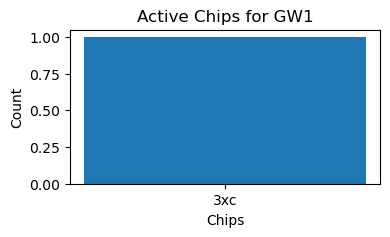

In [42]:
plot_active_chips(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}')

# Captaincy for current GW

In [43]:
def plot_captaincy(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}'):
    # to store captains
    captains = []

    # fetch the team data for each user
    for user_id in user_ids:
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            picks = data['picks']

            for pick in picks:
                if pick['is_captain']==True:
                    player_id = pick['element']
                    player_name = player_to_id_mapping[player_id]
                    captains.append(player_name)

    # make it an ordered list
    captain_counts = Counter(captains)
    sorted_captains = sorted(captain_counts.items(), key=lambda x: x[1], reverse=True)
    captains, counts = zip(*sorted_captains)
    
    # plot captains count
    plt.figure(figsize=(6, 4))
    plt.bar(captains, counts)
    plt.xlabel(f'Captains')
    plt.ylabel('Count')
    plt.title(f'Captains for GW{GW}')
    plt.xticks(rotation=30)
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/captaincy_GW{GW}.png')
    plt.show()

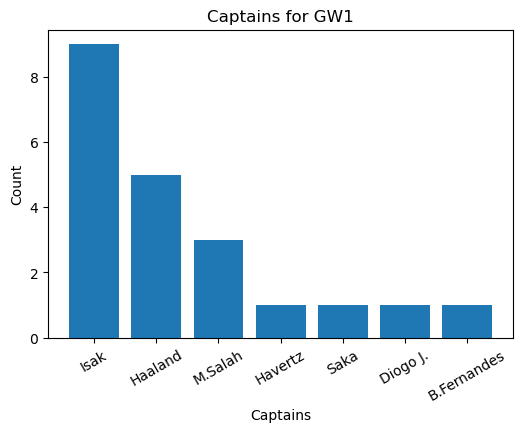

In [44]:
plot_captaincy(user_ids, GW, save_dir=f'league_{league_id}/output/GW{GW}')

# Get % ownership

In [45]:
def plot_most_owned(user_ids, GW, N_most_owned=10, save_dir=f'league_{league_id}/output/GW{GW}'):

    """
    Plots the most owned players for a given gameweek (GW) among a list of user IDs and saves the plot as an image.

    Parameters:
    user_ids (list): List of user IDs.
    GW (int): Gameweek number.
    N_most_owned (int, optional): Number of top owned players to display. Default is 10.
    save_dir (str, optional): Directory path where the plot image will be saved. Default is 'league_{league_id}/most_owned_GW{GW}.png'.

    Returns:
    None
    """
        
    # to store all owned players
    players = []

    # fetch the team data for each user
    for user_id in user_ids:
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            picks = data['picks']

            for pick in picks:
                player_id = pick['element']
                player_name = player_to_id_mapping[player_id]
                players.append(player_name)

    # get the top N most owned players, and their percentages
    player_counts = Counter(players)
    top_N_players = player_counts.most_common(N_most_owned)
    player_names, counts = zip(*top_N_players)
    percent_owned = [count / len(user_ids) for count in counts]

    # Plot the data
    plt.figure(figsize=(10, 6))
    bars = plt.bar(player_names, percent_owned, color='skyblue')
    plt.xlabel('Player')
    plt.ylabel('% Owned')
    plt.title(f'Most Owned Players for GW{GW}')
    plt.xticks(rotation=45)

    # Add percentage on top of each bar
    for bar, percent in zip(bars, percent_owned):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(percent * 100)}%', ha='center', va='bottom')

    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f'{save_dir}/most_owned_GW{GW}.png')
    plt.show()

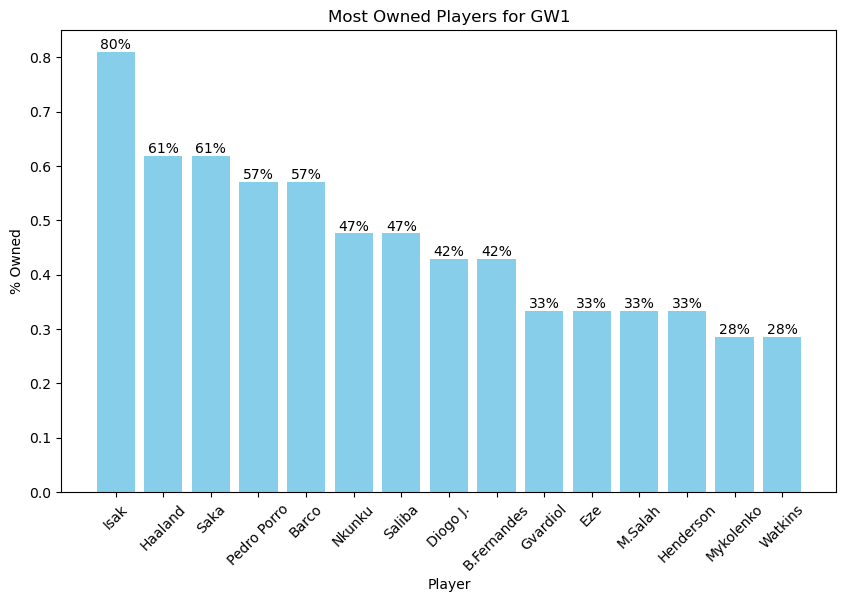

In [46]:
plot_most_owned(user_ids, GW, N_most_owned=15, save_dir=f'league_{league_id}/output/GW{GW}')

# Get top N chips, captain, and squad

In [47]:
def get_top_N(league_id, N):
    '''
    Fetches the top N user IDs in a league.

    Parameters:
    league_id (str): ID of league
    N (int): The top N users to fetch
    '''

    url = f"https://fantasy.premierleague.com/api/leagues-classic/{league_id}/standings/"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        standings = data['standings']['results']
        top_N = standings[:N]
        top_N_user_ids = [entry['entry'] for entry in top_N]
        return top_N_user_ids
    else:
        raise ValueError(f"Failed to fetch data. Status code: {response.status_code}")

In [48]:
top_3_users = get_top_N(league_id, N=3)

In [49]:
def print_top_N_captains(user_ids, GW):
    # to store captains
    user_captains = {}
    
    # fetch the team data for each user
    for user_id in user_ids:
        
        # get user name
        user_name = entry_to_player_mapping[user_id]

        # get data from that user
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            picks = data['picks']

            for pick in picks:
                if pick['is_captain']==True:
                    player_id = pick['element']
                    captain_name = player_to_id_mapping[player_id]
                    user_captains[user_name] = captain_name

    # print the data
    for user, captain in user_captains.items():
        print(f"{user} picked {captain} as captain.")

In [50]:
print_top_N_captains(top_3_users, GW)

In [51]:
def print_top_N_chips(user_ids, GW):
    # to store chips
    user_chips = {}
    
    # fetch the team data for each user
    for user_id in user_ids:
        
        # get user name
        user_name = entry_to_player_mapping[user_id]

        # get data from that user
        url = f"https://fantasy.premierleague.com/api/entry/{user_id}/event/{GW}/picks/"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            chip = data['active_chip']
            user_chips[user_name] = chip

    # print the data
    for user, chip in user_chips.items():
        print(f"{user} used the {chip} chip.")

In [52]:
print_top_N_chips(league_id, GW)

KeyError: '7'